## Thermal Conductivity Fit Analysis
### Developed by Henry Nachman
#### Last Edited: 31 January 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, string, csv, h5py, yaml
from scipy.special import erf

First, we need to find where all our RAW data is

In [2]:
path_to_lib = f"{os.getcwd()}\\lib"
mat_directories = [folder for folder in os.listdir(path_to_lib) if not folder.endswith(".md")]

path_to_RAW = dict()
for mat in mat_directories:
    raw_str = f"{path_to_lib}\\{mat}\\RAW"
    path_to_RAW[mat] = raw_str

print(path_to_RAW)

{'SS304': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS304\\RAW', 'SS305': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS305\\RAW'}


Next, we need to extract each file.

In [3]:
def get_datafiles(raw_path):
    """
    Arguments :
    - raw_path - path to the folder containing the raw data csv files.
    
    Returns :
    - raw_files - array of csv file names containing the raw measurement data.
    """
    all_files = os.listdir(raw_path)
    extension = ".csv"
    raw_files = [file for file in all_files if file.endswith(extension)]
    print(f"Found {len(raw_files)} measurements.")
    return raw_files

Now, lets parse the data from the csv files

In [4]:
def parse_raw(material_name, path_dict, plots=False):
    """
    Arguments : 
    - material_name - a pointer for the material name, this much match the folder name.
    - path_dict     - a dictionary object linking the material name to the path address of the raw files.

    Returns : 
    - big_data  - Array of all measurements concatenated (no reference information).
    - data_dict - A dictionary of data with references as the keys.
    """
    raw_directory = path_dict[material_name]
    all_files = os.listdir(raw_directory)
    extension = ".csv"
    raw_files = [file for file in all_files if file.endswith(extension)]
    
    big_data = np.empty((0,3), float)
    data_dict = dict()
    with open(f"{raw_directory}\\references.txt", 'w') as file:
        for f in raw_files:
            f_path = raw_directory +"\\"+ f
            file1 = np.loadtxt(f_path, dtype=str, delimiter=',')
            file.write(str(file1[0]))
            file.write("\n \n")
            ref_name = f[:-4]
            raw_data = np.array(file1[2:,:], dtype=float)
            big_data = np.append(big_data, raw_data, axis=0)
            data_dict[ref_name] = raw_data
            T, k, koT = raw_data.T
            if plots:
                plt.plot(T, k, '.', label=ref_name)
    if plots:
        plt.legend()
        plt.xlabel("Temperature")
        plt.ylabel("k")
        plt.semilogx()
        plt.semilogy()
        plt.savefig(f"{os.path.split(raw_directory)[0]}\\{material_name}_RAWDATA.pdf", dpi=300, format="pdf")
        plt.show()
        plt.clf()

    return big_data, data_dict

This function will fit the data to polynomials. The fit is done in two stages, a low end fit and a high end fit. The two fits are then connected using an Error Function centered at the discontinuity.

In [5]:
def fit_thermal_conductivity(big_data, save_path, erf_loc = 20, fit_orders = (3,3), fit_types=("k/T", "loglog"), plots=False):
    """
    Arguments :
    - big_data   - Array of measurement data concatenated (should be of shape: [N, 3])
    - save_path  - File path to publish output files and plots.
    - erf_loc     - default=20    - Temperature at which to split the data for fitting (and to place the error function).
    - fit_orders - default=(3,3) - Polynomial fit order (low, high).
    - fit_types  - default=("k/T", "loglog") - defines the type of fit for each regime (low, high).
    - plots      - default=False - Boolean argument, if true, plots are made and saved to save_path.

    Returns :
    - arg_dict - Dictionary of fit arguments - includes low fit, high fit, and combined fit arguments.
    """
    # divide the data array into three columns
    T = big_data[:,0]
    k = big_data[:,1]
    koT = big_data[:,2]

    # Find the low range
    lowT = T[T<erf_loc]
    lowT_k = k[T<erf_loc]
    lowT_koT = koT[T<erf_loc]

    # Find the high range
    hiT = T[T>erf_loc]
    hiT_k = k[T>erf_loc]
    # Take a log10 of the high range
    log_hi_T = np.log10(hiT)
    log_hi_k = np.log10(hiT_k)
    if (len(lowT) == 0) or (len(lowT) ==0):
        print("ERROR  - data split results in 0-length array, please adjust split location")
        print(f"NOTE   - min(T) = {min(T)}, max(T) = {max(T)} ")
    # Fit the low data
    if fit_types[0] == "k/T":
        lofit_full = np.polyfit(lowT, lowT_koT, fit_orders[0], full=True)
        low_fit, residuals_lo, rank_lo, sing_vals_lo, rcond_lo = lofit_full
        low_fit_xs = np.linspace(np.min(lowT), np.max(lowT), 100)
        low_poly1d = np.poly1d(low_fit)


    # Fit the high data
    if fit_types[1] == "loglog":
        hifit_full = np.polyfit(log_hi_T, log_hi_k, fit_orders[1], full=True)
        hi_fit, residuals_hi, rank_hi, sing_vals_hi, rcond_hi = hifit_full
        hi_fit_xs = np.linspace(np.min(log_hi_T), np.max(log_hi_T), 100)
        hi_poly1d = np.poly1d(hi_fit)
        
    # # Combine the fits
    # xrange_total = np.linspace(min(lowT), max(hiT), 100)
    # logk = loglog(xrange_total, low_poly1d, hi_poly1d, erf_place)
    # #

    if plots:
        fig, axs = plt.subplots(2, figsize=(8, 6))
        axs[0].plot(lowT, lowT_koT,'.')
        axs[0].plot(low_fit_xs, np.polyval(low_fit, low_fit_xs))
        axs[0].set_xlabel("T")
        axs[0].set_ylabel("k/T")
        axs[0].title.set_text("Low Temperature Fit")
        axs[1].loglog(10**hi_fit_xs, 10**np.polyval(hi_fit, hi_fit_xs))
        axs[1].loglog(hiT, hiT_k, '.')
        axs[1].grid(True, which="both", ls="-", color='0.65')
        axs[1].set_ylabel("k")
        axs[1].set_xlabel("T")
        axs[1].title.set_text("High Temperature Fit")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.savefig(f"{save_path}\\fits_subplots.pdf", dpi = 300, format="pdf")
        plt.show()
        plt.clf()
        
    low_func = f"{fit_orders[0]} order {fit_types[0]}"
    hi_func = f"{fit_orders[1]} order {fit_types[1]}"
    
    low_param = np.array(low_fit)
    hi_param = np.array(hi_fit)
    all_params = np.append(np.append(low_param, hi_param), erf_loc)

    arg_dict = {"low_function_type"  : low_func,
                "low_fit_param"      : low_param.tolist(),
                "low_fit_range"      : np.array([min(low_fit_xs), max(low_fit_xs)]).tolist(),
                "hi_function_type"   : hi_func,
                "hi_fit_param"       : hi_param.tolist(),
                "hi_fit_range"       : np.array([10**min(hi_fit_xs), 10**max(hi_fit_xs)]).tolist(),
                "combined_function_type" : "loglog",
                "combined_fit_param" : all_params.tolist(),
                "combined_fit_range" : np.array([min(lowT), max(hiT)]).tolist()}
    return arg_dict



Log10 k = Log10 [aT+bT^2+cT^3+3E-9T^5]*0.5*[1-ERF(15(Log10T-1.48)]+[d+eLog10T+f(Log10T)^2+g(log10T)^3+hEXP^(Log10T)]*0.5*[1+ERF(15(Log10T-1.48)]

These functions allow for saving of the data to different file types.

In [6]:
def make_fit_yaml(fit_args, save_path):
    """
    Description : Takes fit arguments and exports a yaml text file with the included information.
    """
    with open(f"{save_path}\\{os.path.split(save_path)[1]}.yaml", 'w') as file:
        for key in fit_args.keys():
            yaml.dump(key, file)
            yaml.dump(np.array(fit_args[key]).tolist(), file)
    return

def generate_alphabet_array(n, case = "l"):
    """
    Description : Generates a list of n letters from the alphabet (used for making the human readable txt files). 
    """
    if case == "l":
        alphabet = list(string.ascii_lowercase)
    else:
        alphabet = list(string.ascii_uppercase)
    return alphabet[:n]
    
def make_fit_dict(fit_args):
    """
    Description : Makes a dictionary of strings with the appropriate formating and headings to be saved in other file formats.
    """
    
    max_fit_param = 0
    num_fit_param_hi = len(fit_args["hi_fit_param"])
    num_fit_param_lo = len(fit_args["low_fit_param"])
    num_fit_param_combined = len(fit_args["combined_fit_param"])

    n = num_fit_param_combined
    result_lo = generate_alphabet_array(num_fit_param_lo, "l")
    result_hi = generate_alphabet_array(num_fit_param_hi, "h")
    result = np.append(result_lo, result_hi)
    result = np.append(result, "erf param")
    result = list(result)
    
    output_array = []
    keys = ["Fit Type", "Low Temp", "High Temp"] + result

    for i in ["low", "hi", "combined"]:
        dict_vals = []
        dict_vals = np.append(dict_vals, np.array(fit_args[f"{i}_function_type"], dtype=str).flatten())
        dict_vals = np.append(dict_vals, np.char.mod('%0.' + str(3) + 'f', np.array(fit_args[f"{i}_fit_range"], dtype=float)).flatten())
        param_str_arr  = np.char.mod('%0.' + str(5) + 'e', np.array(fit_args[f"{i}_fit_param"], dtype=float)).flatten()
        while len(param_str_arr) < len(result):
            param_str_arr = np.append(param_str_arr, "0")
        dict_vals = np.append(dict_vals, param_str_arr)
    
        mat_dict = dict(zip(keys, dict_vals))
        output_array.append(mat_dict)
    return output_array

def make_fit_lh5(fit_args, save_path):
    """
    Description : Takes fit arguments and exports a lh5 file with the included information.
    """
    comp_file = f"{save_path}\\{os.path.split(save_path)[1]}.lh5"
    with h5py.File(comp_file, "w") as f:
        for key in fit_args:
            f.create_dataset(f"{key}", data=fit_args[key])
    return comp_file

This function makes a nice plot with the data and the fits.

In [7]:

def loglog_func(T, low_param, hi_param, erf_param):
    """
    Description : Takes a temperature (or temp array) and fit arguments returns the estimated k value.

    Arguments : 
    - T - temperature at which to estimate the thermal conductivity.
    """
    low_fit = T*np.polyval(low_param, T)
    erf_low = 0.5*(1-erf(15*(np.log10((T)/erf_param))))
    hi_fit = 10**np.polyval(hi_param, np.log10(T))
    erf_hi = 0.5*(1+erf(15*(np.log10(T/erf_param))))
    k = low_fit*erf_low+hi_fit*erf_hi

    return k

In [8]:
def tk_plot(material_name: str, path_dict, data_dict, fit_args, fit_range=[100e-3,25e2], points=True, fits="combined", fill=False, show=True):
    """
    Description : Produces a beautiful plot of the raw data with the fit.

    Arguments :
    - material_name - material name
    - path_dict     - dictionary type of paths to data
    - data_dict     - dictionary of raw data with reference information as keys
    - fit_args      - combined fit arguments
    - fit_range     - default=[100e-3,25e2] -
    - points        - default=True          - Boolean argument, if true, data points are added to the plot.
    - fits          - options: 'combined', 'split', other - defines which fits to plot.
    - fill          - default=False         - Boolean argument, if true, 15% confidence interval is shaded around plot.
    - show          - default=True          - Boolean argument, if true, plot is shown in notebook.

    Returns : 
    - null
    """
    raw_directory = path_dict[material_name]
    markers = ['o', 's', 'd', 'P','3', '*']
    i = 0
    if points:
        for ref_name in data_dict.keys():
            T, k, koT = data_dict[ref_name].T
            plt.plot(T, k, marker=markers[i], ms=7, mfc='none', ls='none',label=ref_name)
            i+=1
            if i == len(markers):
                i = 0
    # low_xs = np.linspace(fit_args["low_fit_range"][0]/5,fit_args["low_fit_range"][1],100)
    low_xs = np.linspace(fit_range[0],fit_args["low_fit_range"][1],100)
    low_fit_val = low_xs*np.polyval(fit_args["low_fit_param"], low_xs)
    # hi_xs = np.linspace(fit_args["hi_fit_range"][0],fit_args["hi_fit_range"][1]*5,100)
    hi_xs = np.linspace(fit_args["hi_fit_range"][0],fit_range[1],100)
    hi_fit_val = 10**np.polyval(fit_args["hi_fit_param"], np.log10(hi_xs))
    if fill:
        plt.fill_between(low_xs, 1.15*low_fit_val, 0.85*low_fit_val, color="b", alpha = 0.3, label="15% confidence")
        plt.fill_between(hi_xs, 1.15*hi_fit_val, 0.85*hi_fit_val, color="b", alpha = 0.3)
    if fits=="split":
        plt.plot(low_xs, low_fit_val, c='b')
        plt.plot(hi_xs, hi_fit_val, c='b')
    if fits=="combined":
        xs = np.logspace(-1,4,100)
        plt.plot(xs, loglog_func(xs, fit_args["low_fit_param"], fit_args["hi_fit_param"], fit_args["combined_fit_param"][-1]), label='combined fit')
    plt.legend()
    plt.xlabel("Temperature (K)")
    plt.ylabel("k")
    plt.title(f"{material_name}")
    plt.semilogx()
    plt.semilogy()
    plt.savefig(f"{os.path.split(raw_directory)[0]}\\{material_name}_fullPlot.pdf", dpi=300, format="pdf")
    if show:
        plt.show()
        plt.clf()
    return

This is code necessary to save fit data to human-readable files and CSVs.

In [9]:
def create_data_table(data, output_file):
    """
    Description : Formats a dictionary in string style for saving to text file formats and saves to txt file.
    """
    # Extract column names from the first dictionary
    columns = list(data[0].keys())

    # Find the maximum width for each column
    column_widths = {column: max(len(str(row[column])) for row in data) for column in columns}
    for key in column_widths.keys():
        if len(key)>column_widths[key]:
            column_widths[key] = len(key)
    # Open the output file in write mode
    with open(output_file, 'w') as file:
        # Write the header row
        file.write('| ' + ' | '.join(column.ljust(column_widths[column]) for column in columns) + ' |\n')
        # Write the separator row
        file.write('| ' + '---'.join(['-' * column_widths[column] for column in columns]) + ' |\n')

        # Write each data row
        for row in data:
            file.write('| ' + ' | '.join(str(row[column]).ljust(column_widths[column]) for column in columns) + ' |\n')
    return

def create_tc_csv(data, output_file):
    """
    Description : Formats a dictionary and saves to csv file.
    """
    # Extract column names from the first dictionary
    columns = list(data[0].keys())

    # Open the output file in write mode with newline='' to ensure consistent line endings
    with open(output_file, 'w', newline='') as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(columns)

        # Write each data row
        for row in data:
            csv_writer.writerow([str(row[column]) for column in columns])
    return


Lets run the above functions for every material currently in the library. 

By removing the loop and specifying mat, the code can be run for a single material

Low-Hi split centered at : 115.95368421052633 ~~ with residual value of: 25.99


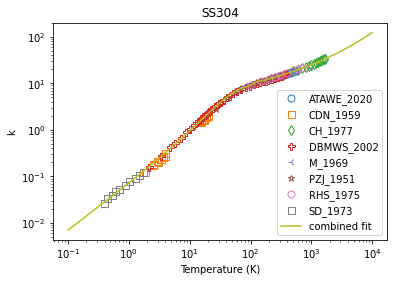

Low-Hi split centered at : 73.93052631578948 ~~ with residual value of: 15.87


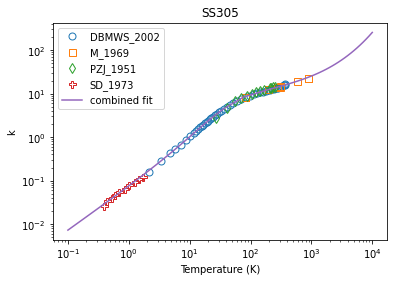

<Figure size 432x288 with 0 Axes>

In [10]:
for mat in path_to_RAW.keys():
    erf_locList = np.linspace(0.39, 200, 20)
    resVal = np.array([])
    for erf_loc in erf_locList:
        ## First, let's collect the raw data from their csv files
        big_data, data_dict = parse_raw(mat, path_to_RAW, plots=False)
        ## Now, let's fit that data by way of the fit function described above.
        fit_args = fit_thermal_conductivity(big_data, 
                                            os.path.split(path_to_RAW[mat])[0], 
                                            erf_loc=erf_loc, fit_orders=(3, 3), plots=False)
        ## With the fit complete, let's output a formatted dictionary with the fit parameters
        output_array = make_fit_dict(fit_args)
        ## We want to figure out the best location for the split in data, so we will compute the residual of the combined fit
        Tdata = np.concatenate([(data_dict[ref_name].T[0]) for ref_name in data_dict])
        kdata = np.concatenate([(data_dict[ref_name].T[1]) for ref_name in data_dict])
        low_param, hi_param, erf_param = fit_args["low_fit_param"], fit_args["hi_fit_param"], fit_args["combined_fit_param"][-1]
        kpred = loglog_func(Tdata, low_param, hi_param, erf_param)
        # and append it to the array resVal
        resVal = np.append(resVal, sum(abs(kpred-kdata)))

    # Now that we have found the residuals of the fits for many different split locations, let's choose the best one.    
    erf_locdict = dict(zip(erf_locList, resVal))
    bestRes = min(erf_locdict.values())
    besterf_loc = [key for key in erf_locdict if erf_locdict[key] == bestRes]
    print(f"Low-Hi split centered at : {besterf_loc[0]} ~~ with residual value of: {bestRes:.2f}")
    
    # We will repeat the above fit with this new 'optimized' split location
    fit_args = fit_thermal_conductivity(big_data, os.path.split(path_to_RAW[mat])[0], erf_loc=besterf_loc, fit_orders=(3, 3), plots=False)
    output_array = make_fit_dict(fit_args)

    # Finally, we will output the fit parameters as a csv, and lh5 file - and plot the data.
    create_data_table(output_array, f"{os.path.split(path_to_RAW[mat])[0]}\\{os.path.split(os.path.split(path_to_RAW[mat])[0])[1]}.txt")
    create_tc_csv(output_array, f"{os.path.split(path_to_RAW[mat])[0]}\\{os.path.split(os.path.split(path_to_RAW[mat])[0])[1]}.csv")
    make_fit_lh5(fit_args, os.path.split(path_to_RAW[mat])[0])
    # PLOTTING CODE
    tk_plot(mat,path_to_RAW, data_dict, fit_args, fit_range = [100e-3, 25e2], points=True, fits="combined", show=True)

Finally, lets output a single human readable (and CSV) file of the fits for each material currently in the library.

In [11]:
def compile_csv(path_to_RAW):
    """
    Description : Compiles the fit data of every material and outputs to a single array.
    """
    output_array = []
    for mat in path_to_RAW.keys():
        file = os.path.split(path_to_RAW[mat])[0]
        max_fit_param = 0
        material_file = np.loadtxt(f"{file}\\{mat}.csv", dtype=str, delimiter=',')
        headers = material_file[0]
        headers = np.append(["Material Name"], headers)
        comb_fit = material_file[-1]
        comb_fit = np.append([f"{mat}"], comb_fit)
        mat_dict = dict(zip(headers, comb_fit))
        output_array.append(mat_dict)

    return output_array

In [12]:
# Call the function to create the data table and write to the file
# output_array = make_output_dict(path_to_RAW)
output_array = compile_csv(path_to_RAW)
create_data_table(output_array, "..\\thermal_conductivity_compilation.txt")
create_tc_csv(output_array, "..\\thermal_conductivity_compilation.csv")

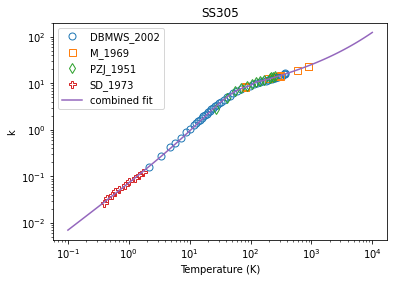

In [13]:
import numpy as np
TCdata = np.loadtxt("..\\thermal_conductivity_compilation.csv", dtype=str, delimiter=',')
headers = TCdata[0]
mat_row = TCdata[1]
# mat_dict = dict(zip(headers, mat_row))
num_hi = sum(1 for c in headers[4:] if c.isupper())
num_low = sum(1 for c in headers[4:-1] if c.islower())
fit_params = mat_row[4:]
low_param, hi_param, erf_param = np.array(fit_params[:num_low], dtype=float), np.array(fit_params[num_low:-1], dtype=float), float(fit_params[-1])

xs = np.logspace(-1,4,100)
tk_plot(mat,path_to_RAW, data_dict, fit_args, fit_range = [100e-3, 25e2], points=True, fits=False, show=False)
plt.plot(xs, loglog_func(xs, low_param, hi_param, erf_param), label='combined fit')
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()